# Notebook to define ensemble for production, cm level
Version developed for ViEWS monthly updates: Fatalities002
## Including ensemble weighting

This notebook defines the ensemble used for production: selects a set of pre-trained models, retrieves and calibrates them, computes weights, and computes and stores the ensemble model predictions.

Models are stored in model storage and most of them specified in the notebook fat_cm_constituentmodels

The notebook draws on the following files in this repository:

Script file: 
    Ensembling.py
    FetchData.py

Lists of models:
    ModelList_cm_{dev_id}.csv (not yet functional)
    List of pickles at local directory (will rewrite to drop dependence on this)

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *
# Other packages
import pickle as pkl

In [2]:
# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
import os

from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated, get_genetic_weights, make_run_from_step
from FetchData import FetchData, RetrieveFromList
from ViewsEstimators import *

# Parallel processing and genetic algorithm
from joblib import Parallel, delayed, cpu_count
from functools import partial
from genetic2 import *
from pathlib import Path

Refreshing


In [3]:
# Common parameters:

dev_id = 'Fatalities002'
run_id = 'Fatalities002'
EndOfHistory = 540
RunGeneticAlgo = True
level = 'cm'
get_future = False

username = os.getlogin()

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

fi_steps = [1,3,6,12,36]

# Specifying partitions - new for 2025
calib_partitioner_dict = {"train":(121,432),"predict":(433,480)}
test_partitioner_dict = {"train":(121,480),"predict":(481,528)}
future_partitioner_dict = {"train":(121,528),"predict":(529,540)}

calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})


In [4]:
import os
home = os.path.expanduser("~")
home

'/Users/alm'

In [5]:

Mydropbox = f'{home}/ViEWS Dropbox/ViEWS/'
localpath = f'{home}/Pickles/'
overleafpath = f'{home}/ViEWS Dropbox/ViEWS/Apps/Overleaf/ViEWS predicting fatalities/Tables/'


print('Dropbox path set to',Mydropbox)
print('Overleaf path set to',overleafpath)
print('Local path set to',localpath)

Dropbox path set to /Users/alm/ViEWS Dropbox/ViEWS/
Overleaf path set to /Users/alm/ViEWS Dropbox/ViEWS/Apps/Overleaf/ViEWS predicting fatalities/Tables/
Local path set to /Users/alm/Pickles/


In [6]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities002_baseline_rf baseline002
1 fatalities002_conflicthistory_rf conflict_ln
2 fatalities002_conflicthistory_gbm conflict_ln
3 fatalities002_conflicthistory_hurdle_lgb conflict_ln
4 fatalities002_conflicthistory_long_xgb conflictlong_ln
5 fatalities002_vdem_hurdle_xgb vdem_short
6 fatalities002_wdi_rf wdi_short
7 fatalities002_topics_rf topics_002
8 fatalities002_topics_xgb topics_002
9 fatalities002_topics_hurdle_lgb topics_002
10 fatalities002_joint_broad_rf joint_broad
11 fatalities002_joint_broad_hurdle_rf joint_broad
12 fatalities002_joint_narrow_xgb joint_narrow
13 fatalities002_joint_narrow_hurdle_xgb joint_narrow
14 fatalities002_joint_narrow_hurdle_lgb joint_narrow
15 fatalities002_all_pca3_xgb all_features
16 fatalities002_aquastat_rf aquastat
17 fatalities002_faostat_rf faostat
18 fatalities002_faoprices_rf faoprices
19 fatalities002_imfweo_rf imfweo
20 fatalities002_Markov_glm joint_narrow
21 fatalities002_Markov_rf joint_narrow


# Retrieve and calibrate predictions

In [7]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, dev_id, level, get_future)

ModelList = CalibratePredictions(ModelList, EndOfHistory, steps)

0 fatalities002_baseline_rf
pr_46_cm_fatalities002_baseline_rf_calib.parquet
pr_46_cm_fatalities002_baseline_rf_test.parquet
1 fatalities002_conflicthistory_rf
pr_46_cm_fatalities002_conflicthistory_rf_calib.parquet
pr_46_cm_fatalities002_conflicthistory_rf_test.parquet
2 fatalities002_conflicthistory_gbm
pr_46_cm_fatalities002_conflicthistory_gbm_calib.parquet
pr_46_cm_fatalities002_conflicthistory_gbm_test.parquet
3 fatalities002_conflicthistory_hurdle_lgb
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_test.parquet
4 fatalities002_conflicthistory_long_xgb
pr_46_cm_fatalities002_conflicthistory_long_xgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_long_xgb_test.parquet
5 fatalities002_vdem_hurdle_xgb
pr_46_cm_fatalities002_vdem_hurdle_xgb_calib.parquet
pr_46_cm_fatalities002_vdem_hurdle_xgb_test.parquet
6 fatalities002_wdi_rf
pr_46_cm_fatalities002_wdi_rf_calib.parquet
pr_46_cm_fatalities002_wdi_rf_test.parquet

In [8]:
ModelList[-2].keys()

dict_keys(['modelname', 'algorithm', 'depvar', 'data_train', 'queryset', 'preprocessing', 'level', 'description', 'long_description', 'predstore_calib', 'predstore_test', 'predictions_calib_df', 'predictions_test_df', 'calib_df_cal_expand', 'test_df_cal_expand', 'calib_df_calibrated', 'test_df_calibrated', 'calibration_gams', 'expanded', 'shiftsize'])

In [9]:
ModelList[-2]['calib_df_calibrated'].isna().sum()

ln_ged_sb_dep    0
step_pred_1      0
step_pred_2      0
step_pred_3      0
step_pred_4      0
step_pred_5      0
step_pred_6      0
step_pred_7      0
step_pred_8      0
step_pred_9      0
step_pred_10     0
step_pred_11     0
step_pred_12     0
step_pred_13     0
step_pred_14     0
step_pred_15     0
step_pred_16     0
step_pred_17     0
step_pred_18     0
step_pred_19     0
step_pred_20     0
step_pred_21     0
step_pred_22     0
step_pred_23     0
step_pred_24     0
step_pred_25     0
step_pred_26     0
step_pred_27     0
step_pred_28     0
step_pred_29     0
step_pred_30     0
step_pred_31     0
step_pred_32     0
step_pred_33     0
step_pred_34     0
step_pred_35     0
step_pred_36     0
dtype: int64

# Genetic algorithm

In [10]:
super_walrus_genes = np.array([0, 0.010, 0.015, 0.020, 0.025, 0.030, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.25, 0.30])
steps_to_optimize = [1,2,3,4,6,9,12,15,18,24,30,36]
generations = 100

RunGeneticAlgo = True

cpus = cpu_count()-2 if cpu_count()>2 else 1
cpus - len(steps_to_optimize)

-6

In [11]:
i_weights_df = get_genetic_weights(run_algorithm=RunGeneticAlgo,mlist=ModelList, steps=steps, steps_to_optimize=steps_to_optimize, generations=generations, cpus=cpus, gene_set=super_walrus_genes)
i_weights_df.head(25)

Estimating genetic weights, current time: 2025-09-25 23:39:10.400607
Refreshing
Refreshing
Refreshing
GEN 0 :GEN 0 :Refreshing
GEN 0 :Refreshing
Refreshing
GEN 0 :AVG FITNESS BEST 10: 39.708592517433, BEST FIT : 42.61257763964779
GEN 1 :AVG FITNESS BEST 10: 18.08180682508398, BEST FIT : 26.409508067000797
GEN 1 :GEN 0 :GEN 0 :AVG FITNESS BEST 10: 42.431751157743165, BEST FIT : 45.66587298804582
GEN 2 :AVG FITNESS BEST 10: 27.760902122354366, BEST FIT : 30.81586567382802
GEN 2 :AVG FITNESS BEST 10: 18.52969469316917, BEST FIT : 22.366464563247167
GEN 1 :AVG FITNESS BEST 10: 12.541693670785302, BEST FIT : 19.50680616390318
GEN 1 :AVG FITNESS BEST 10: 44.22995840194089, BEST FIT : 47.59466587990516
GEN 3 :AVG FITNESS BEST 10: 22.20414355733547, BEST FIT : 24.155330727072386
GEN 2 :AVG FITNESS BEST 10: 30.714640535598807, BEST FIT : 31.44655401817203
GEN 3 :AVG FITNESS BEST 10: 13.529988052402228, BEST FIT : 18.601968198768454
GEN 1 :AVG FITNESS BEST 10: 9.987890920761492, BEST FIT : 14.47

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_27,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36
fatalities002_baseline_rf,0.000,0.025,0.010,0.015,0.0075,0.000,0.000000,0.000000,0.000,0.003333,...,0.0075,0.010000,0.012500,0.015,0.012500,0.010000,0.0075,0.005000,0.002500,0.00
fatalities002_conflicthistory_rf,0.040,0.020,0.120,0.120,0.0950,0.070,0.070000,0.070000,0.070,0.066667,...,0.2000,0.200000,0.200000,0.200,0.193333,0.186667,0.1800,0.173333,0.166667,0.16
fatalities002_conflicthistory_gbm,0.140,0.070,0.010,0.000,0.0000,0.000,0.010000,0.020000,0.030,0.028333,...,0.0550,0.066667,0.078333,0.090,0.085000,0.080000,0.0750,0.070000,0.065000,0.06
fatalities002_conflicthistory_hurdle_lgb,0.140,0.250,0.160,0.120,0.1600,0.200,0.163333,0.126667,0.090,0.126667,...,0.1200,0.106667,0.093333,0.080,0.093333,0.106667,0.1200,0.133333,0.146667,0.16
fatalities002_conflicthistory_long_xgb,0.090,0.015,0.000,0.050,0.1150,0.180,0.123333,0.066667,0.010,0.016667,...,0.0000,0.000000,0.000000,0.000,0.001667,0.003333,0.0050,0.006667,0.008333,0.01
fatalities002_vdem_hurdle_xgb,0.000,0.000,0.000,0.010,0.0175,0.025,0.016667,0.008333,0.000,0.005000,...,0.0050,0.003333,0.001667,0.000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00
fatalities002_wdi_rf,0.015,0.010,0.000,0.000,0.0000,0.000,0.000000,0.000000,0.000,0.000000,...,0.0150,0.016667,0.018333,0.020,0.016667,0.013333,0.0100,0.006667,0.003333,0.00
fatalities002_topics_rf,0.020,0.025,0.030,0.050,0.0250,0.000,0.005000,0.010000,0.015,0.016667,...,0.1200,0.120000,0.120000,0.120,0.130000,0.140000,0.1500,0.160000,0.170000,0.18
fatalities002_topics_xgb,0.050,0.010,0.025,0.050,0.0250,0.000,0.003333,0.006667,0.010,0.040000,...,0.0150,0.010000,0.005000,0.000,0.008333,0.016667,0.0250,0.033333,0.041667,0.05
fatalities002_topics_hurdle_lgb,0.100,0.090,0.060,0.015,0.0775,0.140,0.123333,0.106667,0.090,0.063333,...,0.0275,0.023333,0.019167,0.015,0.012500,0.010000,0.0075,0.005000,0.002500,0.00


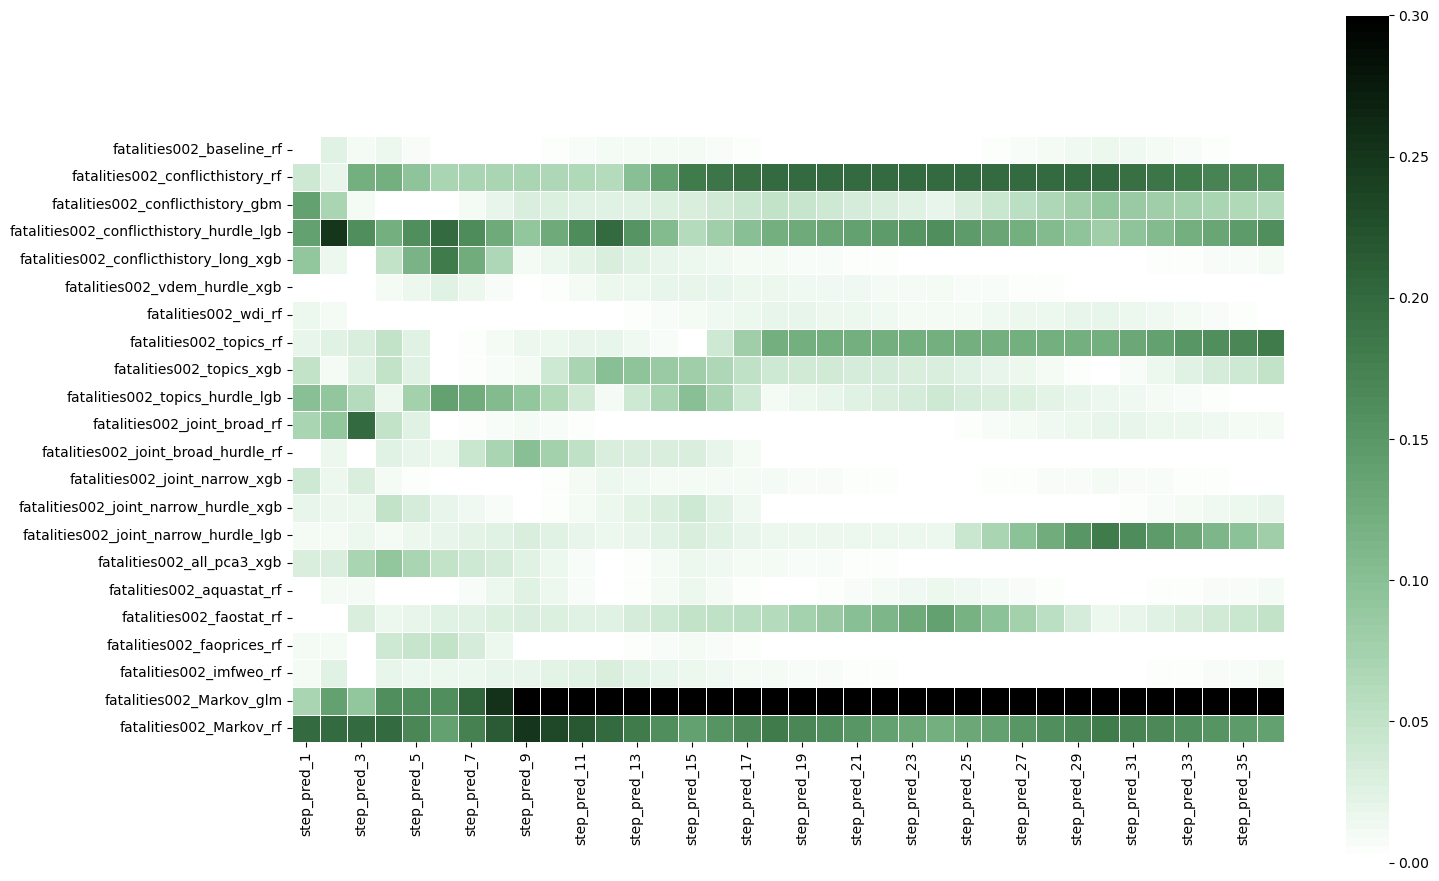

In [12]:
import seaborn as sns
palette = 'vlag'
palette = sns.color_palette('BrBG',n_colors=50)
palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=1, n_colors=100)

fig, ax =plt.subplots(1,figsize=(16,11))
ax = sns.heatmap(i_weights_df, xticklabels=2, linewidths=.5, cmap=palette,square=True)
filename = overleafpath + 'genetic_weights.png'
plt.savefig(filename, dpi=300)

In [13]:
# Constructing dfs to hold the predictions
# A list of dictionaries organizing predictions and information as one step per entry,
# including a dataframe for each step with one column per prediction model
StepEnsembles = []

stepcols = ['ln_ged_sb_dep']
for step in steps:
    stepcols.append('step_pred_' + str(step))
for col in stepcols[1:]:  # Use the baseline as template to construct object
    Step_prediction = {
        'step_pred': col,
        'df_calib': pd.DataFrame(ModelList[0]['calib_df_calibrated']['ln_ged_sb_dep']), 
        'df_test': pd.DataFrame(ModelList[0]['test_df_calibrated']['ln_ged_sb_dep']),
        'ensembles_calib': pd.DataFrame(ModelList[0]['calib_df_calibrated']['ln_ged_sb_dep']),
        'ensembles_test': pd.DataFrame(ModelList[0]['test_df_calibrated']['ln_ged_sb_dep'])
    }
    for model in ModelList:
        modelname = model['modelname']
        Step_prediction['df_calib'][modelname] = model['calib_df_calibrated'][col]
        Step_prediction['df_test'][modelname] = model['test_df_calibrated'][col]
    StepEnsembles.append(Step_prediction)

# Calculating unweighted average ensembles
i = 0
for col in stepcols[1:]:
    # Unweighted average
    StepEnsembles[i]['ensembles_test']['unweighted_average'] = StepEnsembles[i]['df_test'].drop('ln_ged_sb_dep', axis=1).mean(axis=1)
    StepEnsembles[i]['ensembles_calib']['unweighted_average'] = StepEnsembles[i]['df_calib'].drop('ln_ged_sb_dep', axis=1).mean(axis=1)
#    StepEnsembles[i]['ensembles_calib'].loc['unweighted_average'] = StepEnsembles[i]['df_calib'].drop('ln_ged_sb_dep', axis=1).mean(axis=1)
    i = i + 1


In [14]:
ModelList[-1]['calib_df_calibrated']

ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
433      1                     0.0     0.007132     0.007165     0.006416   
         2                     0.0     0.004935     0.004255     0.003133   
         3                     0.0     0.001192    -0.000250    -0.001816   
         4                     0.0     0.033392     0.041688     0.056573   
         5                     0.0    -0.000739    -0.000765    -0.001425   
...                            ...          ...          ...          ...   
480      242                   0.0     0.015359     0.014987     0.015514   
         243                   0.0     0.006743     0.006719     0.006801   
         244                   0.0     0.037771     0.044920     0.061689   
         245                   0.0     1.017219     1.282187     1.432699   
         246                   0.0     3.067625     2.318461     2.434637   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
433      1              0.006604     0.006541     0.007690     0.008364   
         2              0.002808     0.001618     0.002470     0.001940   
         3             -0.000883    -0.003210    -0.003204    -0.005462   
         4              0.057031     0.063446     0.051791     0.061303   
         5             -0.000308    -0.002826    -0.002822    -0.004656   
...                          ...          ...          ...          ...   
480      242            0.019344     0.025558     0.021312     0.028427   
         243            0.007156     0.006534     0.009260     0.011833   
         244            0.064740     0.066654     0.076623     0.091286   
         245            1.612603     1.571508     2.210748     3.023416   
         246            1.831236     2.447638     3.304593     2.148559   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
433      1              0.004911     0.008428  ...      0.028436   
         2              0.000093     0.001139  ...      0.013799   
         3             -0.005366    -0.006707  ...      0.002199   
         4              0.050169     0.076367  ...      0.059104   
         5             -0.004573    -0.006545  ...      0.000149   
...                          ...          ...  ...           ...   
480      242            0.031108     0.039463  ...      0.071984   
         243            0.009835     0.010559  ...      0.026730   
         244            0.091061     0.107694  ...      0.465765   
         245            2.612475     2.046449  ...      2.018732   
         246            2.529407     2.771512  ...      1.965858   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
433      1               0.034403      0.037098      0.039133      0.037783   
         2               0.016711      0.018791      0.020864      0.020746   
         3               0.002284      0.004424      0.006930      0.008337   
         4               0.066016      0.073192      0.080205      0.078438   
         5               0.000060      0.002147      0.004601      0.006608   
...                           ...           ...           ...           ...   
480      242             0.081831      0.079730      0.083158      0.086882   
         243             0.030487      0.033278      0.036843      0.037556   
         244             0.489879      0.468476      0.492997      0.540140   
         245             2.088856      2.060025      2.525334      2.188053   
         246             1.876642      1.884696      1.895837      1.895591   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                

In [15]:
StepEnsembles[0]['ensembles_calib']['unweighted_average']

month_id  country_id
433       1             0.005552
          2             0.001562
          3             0.001527
          4             0.023297
          5             0.004779
                          ...   
480       242           0.022851
          243           0.005708
          244           0.034451
          245           0.717435
          246           1.606732
Name: unweighted_average, Length: 9168, dtype: float64

In [16]:
i_weights_df.index.values

array(['fatalities002_baseline_rf', 'fatalities002_conflicthistory_rf',
       'fatalities002_conflicthistory_gbm',
       'fatalities002_conflicthistory_hurdle_lgb',
       'fatalities002_conflicthistory_long_xgb',
       'fatalities002_vdem_hurdle_xgb', 'fatalities002_wdi_rf',
       'fatalities002_topics_rf', 'fatalities002_topics_xgb',
       'fatalities002_topics_hurdle_lgb', 'fatalities002_joint_broad_rf',
       'fatalities002_joint_broad_hurdle_rf',
       'fatalities002_joint_narrow_xgb',
       'fatalities002_joint_narrow_hurdle_xgb',
       'fatalities002_joint_narrow_hurdle_lgb',
       'fatalities002_all_pca3_xgb', 'fatalities002_aquastat_rf',
       'fatalities002_faostat_rf', 'fatalities002_faoprices_rf',
       'fatalities002_imfweo_rf', 'fatalities002_Markov_glm',
       'fatalities002_Markov_rf'], dtype=object)

In [17]:

# Calculating weighted average ensembles
# Based on the weights_df dataframe filled with Mihai's weights above

def ensemble_predictions(yhats, weights):
    # make predictions
    yhats = np.array(yhats)
    # weighted sum across ensemble members
    result = np.dot(weights,yhats)
    return result

# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

mult_dict={i_weights_df.index.values[i]:i_weights_df['step_pred_1'][i] for i in range(len(i_weights_df['step_pred_1']))}

i = 0
for col in stepcols[1:]:
    # Unweighted average
    df_calib = StepEnsembles[i]['df_calib'].drop('ln_ged_sb_dep', axis=1)
    df_test = StepEnsembles[i]['df_test'].drop('ln_ged_sb_dep', axis=1)
    StepEnsembles[i]['ensembles_calib']['weighted_average'] = (df_calib.mul(mult_dict,axis='columns')).sum(axis=1)
    StepEnsembles[i]['ensembles_test']['weighted_average'] =  (df_test.mul(mult_dict,axis='columns')).sum(axis=1)
    print('calib_sum',(df_calib.mul(mult_dict,axis='columns')).sum(axis=1))
    i = i + 1

calib_sum month_id  country_id
433       1             0.001650
          2             0.000753
          3            -0.000047
          4             0.021604
          5             0.008221
                          ...   
480       242           0.032619
          243           0.011313
          244           0.025822
          245           0.857650
          246           2.047630
Length: 9168, dtype: float64
calib_sum month_id  country_id
433       1             0.000680
          2             0.003833
          3             0.002688
          4             0.025741
          5             0.003273
                          ...   
480       242           0.023453
          243           0.007099
          244           0.024449
          245           0.985322
          246           2.737591
Length: 9168, dtype: float64
calib_sum month_id  country_id
433       1             0.000101
          2            -0.002017
          3            -0.003050
          4             

In [18]:
StepEnsembles[0]['df_calib']

ln_ged_sb_dep  fatalities002_baseline_rf  \
month_id country_id                                             
433      1                     0.0                   0.003912   
         2                     0.0                   0.000947   
         3                     0.0                   0.000947   
         4                     0.0                   0.035346   
         5                     0.0                   0.000947   
...                            ...                        ...   
480      242                   0.0                   0.029153   
         243                   0.0                   0.004094   
         244                   0.0                   0.032212   
         245                   0.0                   0.650970   
         246                   0.0                   1.110132   

                     fatalities002_conflicthistory_rf  \
month_id country_id                                     
433      1                                   0.001658   
         2                                   0.001658   
         3                                   0.001658   
         4                                   0.001658   
         5                                   0.001658   
...                                               ...   
480      242                                 0.002065   
         243                                 0.001658   
         244                                 0.001938   
         245                                 0.261189   
         246                                 2.327436   

                     fatalities002_conflicthistory_gbm  \
month_id country_id                                      
433      1                                   -0.004280   
         2                                   -0.004280   
         3                                   -0.004280   
         4                                    0.035057   
         5                                    0.057923   
...                                                ...   
480      242                                  0.057739   
         243                                  0.055807   
         244                                 -0.002108   
         245                                  0.772886   
         246                                  2.281162   

                     fatalities002_conflicthistory_hurdle_lgb  \
month_id country_id                                             
433      1                                           0.000785   
         2                                           0.000188   
         3                                           0.000352   
         4                                           0.004079   
         5                                           0.000419   
...                                                       ...   
480      242                                         0.079373   
         243                                         0.000200   
         244                                         0.017239   
         245                                         0.894862   
         246                                         1.450678   

                     fatalities002_conflicthistory_long_xgb  \
month_id country_id                                           
433      1                                         0.002499   
         2                                         0.002499   
         3                                         0.002499   
         4                                         0.028375   
         5                                         0.002499   
...                                                     ...   
480      242                                       0.020409   
         243                                       0.002499   
         244                                       0.007853   
         245                                       0.511645   
         246                                       1.685244   

            

In [19]:
i_weights_df.columns

Index(['step_pred_1', 'step_pred_2', 'step_pred_3', 'step_pred_4',
       'step_pred_5', 'step_pred_6', 'step_pred_7', 'step_pred_8',
       'step_pred_9', 'step_pred_10', 'step_pred_11', 'step_pred_12',
       'step_pred_13', 'step_pred_14', 'step_pred_15', 'step_pred_16',
       'step_pred_17', 'step_pred_18', 'step_pred_19', 'step_pred_20',
       'step_pred_21', 'step_pred_22', 'step_pred_23', 'step_pred_24',
       'step_pred_25', 'step_pred_26', 'step_pred_27', 'step_pred_28',
       'step_pred_29', 'step_pred_30', 'step_pred_31', 'step_pred_32',
       'step_pred_33', 'step_pred_34', 'step_pred_35', 'step_pred_36'],
      dtype='object')

In [20]:
# Reshape the ensemble predictions
EnsembleList = []
genetic = {
        'modelname': 'ensemble_genetic',
        'algorithm': '',
        'depvar': "ln_ged_sb_dep",
        'calib_df_calibrated': ModelList[0]['calib_df_calibrated'].copy(),
        'test_df_calibrated': ModelList[0]['test_df_calibrated'].copy(),
    }    

for step in StepEnsembles:
    colname = step['step_pred']
    print(colname)
    genetic['calib_df_calibrated'][colname] = step['ensembles_calib']['weighted_average']
    genetic['test_df_calibrated'][colname] = step['ensembles_test']['weighted_average']

EnsembleList.append(genetic)


step_pred_1
step_pred_2
step_pred_3
step_pred_4
step_pred_5
step_pred_6
step_pred_7
step_pred_8
step_pred_9
step_pred_10
step_pred_11
step_pred_12
step_pred_13
step_pred_14
step_pred_15
step_pred_16
step_pred_17
step_pred_18
step_pred_19
step_pred_20
step_pred_21
step_pred_22
step_pred_23
step_pred_24
step_pred_25
step_pred_26
step_pred_27
step_pred_28
step_pred_29
step_pred_30
step_pred_31
step_pred_32
step_pred_33
step_pred_34
step_pred_35
step_pred_36


In [21]:
step['ensembles_test'].describe()

,ln_ged_sb_dep,unweighted_average,weighted_average
count,9168.000000,9168.000000,9168.000000
mean,0.551843,0.617480,0.631936
std,1.461066,1.259170,1.267721
min,0.000000,0.010764,0.014140
25%,0.000000,0.020276,0.023589
50%,0.000000,0.055064,0.056520
75%,0.000000,0.342704,0.391949
max,11.731483,9.132433,9.834655


In [22]:
df_calib

fatalities002_baseline_rf  \
month_id country_id                              
433      1                            0.098712   
         2                            0.013751   
         3                            0.013548   
         4                            0.071696   
         5                            0.013751   
...                                        ...   
480      242                          0.256125   
         243                          0.261421   
         244                          0.029945   
         245                          1.372679   
         246                          2.675668   

                     fatalities002_conflicthistory_rf  \
month_id country_id                                     
433      1                                   0.049305   
         2                                   0.018025   
         3                                   0.018025   
         4                                   0.064606   
         5                                   0.018025   
...                                               ...   
480      242                                 0.069499   
         243                                 0.050508   
         244                                 0.029563   
         245                                 3.341521   
         246                                 3.055228   

                     fatalities002_conflicthistory_gbm  \
month_id country_id                                      
433      1                                    0.053929   
         2                                    0.029729   
         3                                    0.028781   
         4                                    0.017814   
         5                                    0.034393   
...                                                ...   
480      242                                  0.120021   
         243                                  0.049397   
         244                                  0.063912   
         245                                  2.706048   
         246                                  4.678067   

                     fatalities002_conflicthistory_hurdle_lgb  \
month_id country_id                                             
433      1                                           0.029880   
         2                                           0.029172   
         3                                           0.028954   
         4                                           0.033892   
         5                                           0.028785   
...                                                       ...   
480      242                                         0.070847   
         243                                         0.038362   
         244                                         0.067753   
         245                                         3.183671   
         246                                         4.840731   

                     fatalities002_conflicthistory_long_xgb  \
month_id country_id                                           
433      1                                         0.262731   
         2                                         0.017386   
         3                                         0.000984   
         4                                         0.038201   
         5                                        -0.000831   
...                                                     ...   
480      242                                       0.074825   
         243                                       0.050916   
         244                                       0.042647   
         245                                       3.315828   
         246                                       3.343462   

                     fatalities002_vdem_hurdle_xgb  fatalities002_wdi_rf  \
month_id country_id                                                        
433      1                                0.025391     

In [23]:
StepEnsembles[35]['ensembles_calib']['unweighted_average'].describe()

count    9168.000000
mean        0.513222
std         1.098886
min         0.011341
25%         0.019226
50%         0.035022
75%         0.255037
max         6.556404
Name: unweighted_average, dtype: float64

In [24]:
# Save ensemble predictions
predstore_calib = level +  '_' + genetic['modelname'] + '_calib'
genetic['calib_df_calibrated'].forecasts.set_run(run_id)
genetic['calib_df_calibrated'].forecasts.to_store(name=predstore_calib, overwrite = True)
predstore_test = level +  '_' + genetic['modelname'] + '_test'
genetic['test_df_calibrated'].forecasts.set_run(run_id)
genetic['test_df_calibrated'].forecasts.to_store(name=predstore_test, overwrite = True)

In [25]:
genetic['test_df_calibrated']

ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
481      1                0.000000     0.001476     0.012484     0.004380   
         2                0.000000     0.000507     0.003533     0.003314   
         3                0.000000    -0.001064     0.006227     0.012532   
         4                0.000000     0.074990     0.217390     0.080901   
         5                0.000000     0.007459     0.002374     0.007555   
...                            ...          ...          ...          ...   
528      242              0.000000     0.150374     0.183995     0.196732   
         243              1.609438     0.449797     0.542258     0.260962   
         244              0.000000     0.244816     0.258643     0.411068   
         245              5.916202     6.400361     6.079801     5.359090   
         246              0.000000     0.501438     0.594107     0.732876   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
481      1             -0.003297     0.017846     0.003679     0.014224   
         2             -0.004138     0.000168     0.001436     0.011689   
         3              0.013936     0.023308     0.014243     0.003300   
         4              0.207009     0.418111     0.192269     0.146063   
         5             -0.004498    -0.000649     0.000291    -0.001797   
...                          ...          ...          ...          ...   
528      242            0.181680     0.204907     0.181634     0.243353   
         243            0.136787     0.199305     0.169546     0.310858   
         244            0.336576     0.338158     0.353229     0.442379   
         245            5.011556     5.208852     5.021400     4.188991   
         246            0.855919     1.051773     1.061521     0.996219   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
481      1              0.013171     0.009595  ...      0.009430   
         2              0.009560     0.008414  ...      0.005962   
         3              0.005431     0.000110  ...      0.003928   
         4              0.118819     0.228179  ...      0.160047   
         5              0.003467    -0.003857  ...      0.004457   
...                          ...          ...  ...           ...   
528      242            0.325376     0.301612  ...      1.425576   
         243            0.240376     0.284415  ...      0.223883   
         244            0.475108     0.787910  ...      0.114033   
         245            2.567057     1.759980  ...      2.217750   
         246            1.273329     1.624371  ...      2.791313   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
481      1               0.009711      0.014394      0.011306      0.012656   
         2               0.007459      0.009381      0.010369      0.013567   
         3               0.004990      0.006878      0.008086      0.009586   
         4               0.133878      0.166377      0.229152      0.196687   
         5               0.004784      0.006394      0.008115      0.010056   
...                           ...           ...           ...           ...   
528      242             1.443840      0.730054      0.964216      0.912055   
         243             0.133746      0.230293      0.205382      0.543383   
         244             0.139413      0.103172      0.136537      0.138235   
         245             2.652958      2.378515      2.266759      2.741086   
         246             2.804890      2.810066      2.343986      2.465332   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                

In [26]:
genetic['test_df_calibrated'].describe()

,ln_ged_sb_dep,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,...,step_pred_27,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36
count,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,...,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000
mean,0.551843,0.570702,0.577199,0.574158,0.570409,0.584489,0.578035,0.578305,0.578281,0.581088,...,0.626999,0.610198,0.622119,0.615634,0.621702,0.620304,0.625612,0.626688,0.641885,0.631936
std,1.461066,1.366065,1.369865,1.344229,1.339836,1.343681,1.335806,1.322333,1.315742,1.316707,...,1.301747,1.258797,1.308507,1.267444,1.270795,1.263055,1.278388,1.270888,1.302568,1.267721
min,0.000000,-0.001189,0.000305,-0.006421,-0.006656,-0.001874,-0.000229,-0.002905,0.001568,-0.004800,...,0.003004,0.004000,0.002915,0.007086,0.008235,0.010199,0.011069,0.005022,0.010680,0.014140
25%,0.000000,0.001843,0.003129,0.004227,-0.002609,0.000781,0.001933,0.004242,0.005388,0.004934,...,0.009519,0.010510,0.013129,0.014726,0.016118,0.017457,0.018850,0.017405,0.020350,0.023589
50%,0.000000,0.009299,0.007779,0.010446,0.005998,0.011999,0.009395,0.014420,0.018833,0.016507,...,0.038362,0.041401,0.041495,0.042751,0.045802,0.043918,0.047838,0.050165,0.053082,0.056520
75%,0.000000,0.173913,0.196847,0.217158,0.205165,0.228492,0.212746,0.220065,0.232484,0.225949,...,0.435109,0.373391,0.389765,0.405237,0.382512,0.366362,0.366700,0.393100,0.412640,0.391949
max,11.731483,8.257787,8.259925,8.096360,7.663316,7.896831,7.711683,7.735266,7.752689,7.645230,...,7.448588,6.952713,8.321290,7.120656,7.060357,7.195672,7.223729,7.192654,7.722354,9.834655


In [27]:
# See which genetic ensembles are in prediction storage
ViewsMetadata().with_name('genetic').fetch()

,id,name,file_name,runs_id,model_generations_id,user_name,spatial_loa,temporal_loa,ds,osa,time_min,time_max,space_min,space_max,steps,target,prediction_columns,date_written,description,deleted
0,1137,cm_ensemble_genetic_f505,pr_33_cm_ensemble_genetic_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-03-19 08:09:49.362072+00:00,None,False
1,12013,cm_ensemble_genetic_exp_exp_calib,pr_33_cm_ensemble_genetic_exp_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:27.861484+00:00,None,False
2,12014,cm_ensemble_genetic_exp_exp_test,pr_33_cm_ensemble_genetic_exp_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:34.024314+00:00,None,False
3,12017,cm_ensemble_genetic_exp_calib,pr_33_cm_ensemble_genetic_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:40:57.763694+00:00,None,False
4,12018,cm_ensemble_genetic_exp_test,pr_33_cm_ensemble_genetic_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:41:06.365460+00:00,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,22823,cm_genetic_ensemble_dich_f546,pr_46_cm_genetic_ensemble_dich_f546.parquet,46,1,angelica,c,m,False,False,547,582,1,246,[],step_combined,[],2025-07-21 13:57:45.669217+00:00,None,False
91,22908,cm_genetic_ensemble_f547,pr_46_cm_genetic_ensemble_f547.parquet,46,1,angelica,c,m,False,False,548,583,1,246,[],step_combined,[],2025-08-28 13:03:58.763110+00:00,None,False
92,22909,cm_genetic_ensemble_dich_f547,pr_46_cm_genetic_ensemble_dich_f547.parquet,46,1,angelica,c,m,False,False,548,583,1,246,[],step_combined,[],2025-08-28 13:03:59.649211+00:00,None,False
93,23014,cm_ensemble_genetic_calib,pr_46_cm_ensemble_genetic_calib.parquet,46,1,angelica,c,m,False,True,433,480,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2025-09-26 00:03:00.855822+00:00,None,False


In [28]:
print('All done!')

All done!
